# Build transformer from scratch

In [1]:
%run -i transformer.py

In [2]:
torch.manual_seed(42)

## 1. Unit Test

In [3]:
max_seq_len = 4
input_dim, embed_dim = 2, 6

### 1.1 Test WordEmbedding

In [4]:
x = torch.rand(2, 2).unsqueeze(0)
assert x.shape == (1, 2, 2)

we = WordEmbedding(input_dim=input_dim, embed_dim=embed_dim)
xe = we(x)
assert xe.shape == (1, 2, 6)

### 1.2 Test PositionEmbedding

In [5]:
pe = PositionEmbedding(max_seq_len=4, model_dim=embed_dim)
xpe = pe(xe)
assert xpe.shape == (1, 2, 6)

In [6]:
expected = torch.tensor([[[0.0000, 1.0000], [0.8415, 0.5403]]])
pe = PositionEmbedding(max_seq_len=2, model_dim=2)
actual = pe.pe
assert torch.allclose(expected, actual, 1e-4)
actual

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

### 1.3 Test MultiHeadAttention

In [7]:
x = torch.rand(2, 6).float().unsqueeze(0)
print(f"x shape: {x.shape}")
print(f"x: {x}")

mha = MultiHeadAttention(
    input_dim=embed_dim, 
    n_heads=3, 
    max_seq_len=max_seq_len,
)
y = mha(x, is_masked=False)
print(f"y shape: {y.shape}")
y

x shape: torch.Size([1, 2, 6])
x: tensor([[[0.2969, 0.8317, 0.1053, 0.2695, 0.3588, 0.1994],
         [0.5472, 0.0062, 0.9516, 0.0753, 0.8860, 0.5832]]])
y shape: torch.Size([1, 2, 6])


tensor([[[ 0.1410, -0.2415, -0.0318,  0.3922, -0.4950, -0.0911],
         [ 0.1424, -0.2383, -0.0315,  0.3907, -0.4926, -0.0913]]],
       grad_fn=<ViewBackward0>)

### 1.4 Test SelfAttentionBlock

In [8]:
sab = SelfAttentionBlock(
    input_dim=embed_dim, 
    n_heads=3, 
    max_seq_len=max_seq_len,
)
y = sab(x)
assert y.shape == (1, 2, 6)
y

tensor([[[ 0.4230,  0.5208,  0.1785,  0.0954,  0.3441,  0.2695],
         [ 0.6548, -0.3133,  1.0914, -0.0742,  1.1456,  0.7610]]],
       grad_fn=<AddBackward0>)

### 1.5 Test CrossAttentionBlock

In [9]:
cab = CrossAttentionBlock(
    input_dim=embed_dim, 
    n_heads=3, 
    max_seq_len=max_seq_len,
)
h = torch.rand(x.shape)
y = cab(x, h)
assert y.shape == (1, 2, 6)
y

tensor([[[ 0.4657,  0.6793,  0.2087,  0.4324,  0.3082,  0.9980],
         [ 0.8305, -0.1967,  1.0616,  0.1902,  0.8449,  1.2522]]],
       grad_fn=<AddBackward0>)

### 1.6 Test FeedForwardBlock

In [10]:
ffn = FeedForwardBlock(
    input_dim=embed_dim,
    hidden_dim=2*embed_dim,
    output_dim=embed_dim,
)
y = ffn(x)
assert y.shape == (1, 2, 6)
y


tensor([[[ 0.1941,  0.3956,  0.2387,  0.4547,  0.7300,  0.1099],
         [ 0.6936, -0.4001,  0.9455,  0.0020,  1.0205,  0.8613]]],
       grad_fn=<AddBackward0>)

### 1.7 Test Encoder

In [11]:
encoder = Encoder(
    input_dim=embed_dim, 
    ffn_hidden_dim=2*embed_dim,
    n_heads=3, 
    max_seq_len=max_seq_len
)
y = encoder(x)
assert y.shape == (1, 2, 6)
y

tensor([[[ 0.0229,  0.6373,  0.9636,  0.5993,  1.0467,  0.6053],
         [ 0.2535, -0.0047,  1.0777, -0.2200,  1.0148,  1.1037]]],
       grad_fn=<AddBackward0>)

### 1.8 Test Decoder

In [12]:
decoder = Decoder(
    input_dim=embed_dim, 
    ffn_hidden_dim=2*embed_dim,
    n_heads=3, 
    max_seq_len=max_seq_len
)
y = decoder(x, h)
assert y.shape == (1, 2, 6)
y

tensor([[[ 0.4443,  0.4832,  0.6520, -0.1377,  0.9540,  0.2160],
         [ 0.6955, -0.1804,  1.1963, -0.3065,  1.6590,  0.4834]]],
       grad_fn=<AddBackward0>)

### 1.9 Test Encoders

In [13]:
encoders = Encoders(
    n_layers = 2,
    input_dim = input_dim, 
    embed_dim = embed_dim,
    ffn_hidden_dim = 2 * embed_dim,
    n_heads = 3, 
    max_seq_len = 4,
    dropout_rate = 0.1
)

In [14]:
x = torch.rand(2, 2).float().unsqueeze(0)
y = encoders(x)
assert y.shape == (1, 2, 6)
y

tensor([[[-1.4552,  0.7041, -0.2659,  0.0997, -0.7425,  1.6597],
         [ 1.0727, -1.0704, -0.2171,  0.3087, -1.3805,  1.2866]]],
       grad_fn=<NativeLayerNormBackward0>)

### 1.10 Test Decoders

In [15]:
decoders = Decoders(
    n_layers = 1,
    input_dim = input_dim, 
    embed_dim = embed_dim,
    ffn_hidden_dim = 2 * embed_dim,
    n_heads = 3, 
    max_seq_len = 4,
    dropout_rate = 0.1
)
h = torch.rand(2, embed_dim).float().unsqueeze(0)
y = decoders(x, h)
assert y.shape == (1, 2, 2)
y

tensor([[[ 0.3198,  0.5929],
         [-0.4275,  0.0638]]], grad_fn=<ViewBackward0>)

### 1.11 Test Transformer

In [16]:
transformer = Transformer(
    n_layers = 1,
    input_dim = input_dim, 
    embed_dim = embed_dim,
    ffn_hidden_dim = 2 * embed_dim,
    n_heads = 3, 
    max_seq_len = 4,
    dropout_rate = 0.1
)
y = transformer(x)
assert y.shape == (1, 2, 2)
y

tensor([[[ 0.4592, -0.2402],
         [-0.5283,  0.0123]]], grad_fn=<ViewBackward0>)

## 2. Quad Vertex Sequence Dataset

## 2.1 Data Generator

In [17]:
import matplotlib.pyplot as plt
import numpy as np


In [18]:
np.random.seed(13)

quads = []
directions = []
clockwises = []
m = 1
n = 4
bases = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])  # counter-clockwise
for _ in range(m):
    start = np.random.randint(0, n)
    direct = np.random.choice([-1, 1], replace=True)
    corners = []
    clockwise = []
    for step in range(n):
        index = (start + step * direct) % n
        clockwise.append(index)
        base = bases[index]
        noice = np.random.randn(2) * 0.1
        vertex = base + noice
        corners.append(vertex)
        # print(f"base: {base}, noice: {noice}, vertex: {vertex}")
        # print(f"step * direct: {step * direct}, start: {start}, index: {index}")
    quads.append(corners)
    directions.append(direct)
    clockwises.append(clockwise)

for d, c, q in zip(directions, clockwises, quads):
    print(f"direction: {d}")
    print(f"clockwises: {c}\ncorners:")
    for v in q:
        print(f"\t{v}")
    print("-" * 50)
    

direction: -1
clockwises: [2, 1, 0, 3]
corners:
	[-0.93384498 -1.05354337]
	[-0.77933645  0.90579767]
	[1.06325685 1.12307414]
	[ 0.96859108 -1.01433899]
--------------------------------------------------


In [19]:
class QuadVertexSeqGenerator:
    def __init__(self, n_samples: int, n_vertices: int = 4, seed: int = 13):
        self.n_samples = n_samples    # sequence length
        self.n_vertices = n_vertices  # count of quad corners
        self.seed = seed

    def __call__(self):
        np.random.seed(self.seed)
        m, n = self.n_samples, self.n_vertices

        quads = []
        directions = []
        bases = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])  # counter-clockwise!
        for _ in range(m):
            start = np.random.randint(0, n)
            direct = np.random.choice([-1, 1], replace=True)    # -1: clockwise, 1: counter-clockwise
            clockwise = 1 if direct == -1 else 0
            corners = []
            for step in range(n):
                index = (start + step * direct) % n
                base = bases[index]
                noice = np.random.randn(2) * 0.1
                vertex = base + noice
                corners.append(vertex)
            quads.append(corners)
            directions.append(clockwise)
        return np.array(quads), np.array(directions)
    
    def plot(self, n_rows: int, n_cols: int):
        points, directions = self()
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        axs = axs.flatten()
        
        for e, ax in enumerate(axs):
            pred_corners = points[e]
            clockwise = directions[e]
            for i in range(4):
                color = 'k'
                ax.scatter(*pred_corners.T, c=color, s=400)
                if i == 3:
                    start = -1
                else:
                    start = i
                ax.plot(*pred_corners[[start, start+1]].T, c='k', lw=2, alpha=.5, linestyle='-')
                ax.text(*(pred_corners[i] - np.array([.04, 0.04])), str(i+1), c='w', fontsize=12)
                if directions is not None:
                    ax.set_title(f'{"Counter-" if not clockwise else ""}Clockwise (y={clockwise})', fontsize=14)

            ax.set_xlabel(r"$x_0$")
            ax.set_ylabel(r"$x_1$", rotation=0)
            ax.set_xlim([-1.5, 1.5])
            ax.set_ylim([-1.5, 1.5])

        fig.tight_layout()
        return fig

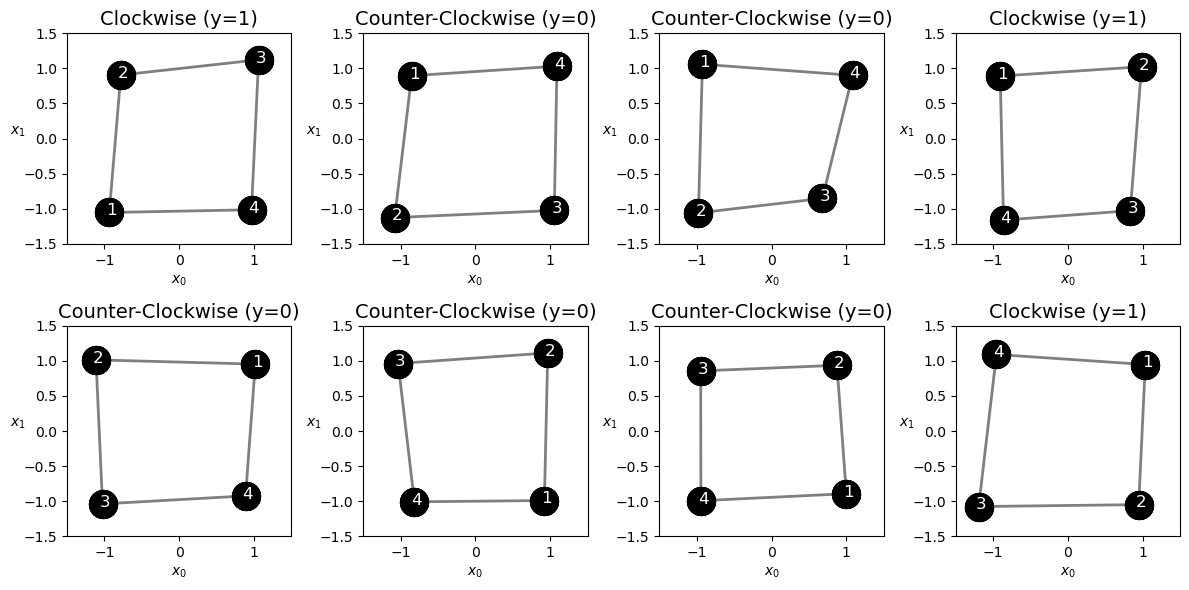

In [20]:
m, n = 8, 4
gen = QuadVertexSeqGenerator(n_samples=m, n_vertices=n, seed=13)
fig = gen.plot(n_rows=2, n_cols=m//2)

## 3. Quad Vertex Sequence Direction Classification

### 3.1 Data preparation

In [21]:
batch_size = 16

#### 3.1.1 Training Dataset

In [22]:
train_data_gen = QuadVertexSeqGenerator(
    n_samples=128,
    n_vertices=4,
    seed=13
)
quads, clockwises = train_data_gen()
print(f"quads shape: {quads.shape}")
print(f"clockwises shape: {clockwises.shape}")
quads[0], clockwises[0]

quads shape: (128, 4, 2)
clockwises shape: (128,)


(array([[-0.93384498, -1.05354337],
        [-0.77933645,  0.90579767],
        [ 1.06325685,  1.12307414],
        [ 0.96859108, -1.01433899]]),
 1)

In [23]:
from torch.utils.data import TensorDataset

x_train = torch.as_tensor(quads).float()
t_train = torch.as_tensor(clockwises).float().view(-1, 1)
print(f"x_train shape: {x_train.shape}")
print(f"t_train shape: {t_train.shape}")

x_train shape: torch.Size([128, 4, 2])
t_train shape: torch.Size([128, 1])


In [24]:
train_set = TensorDataset(x_train, t_train)

In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_set,
    shuffle=True,
    batch_size=batch_size
)

#### 3.1.2 Test Dataset

In [26]:
val_data_gen = QuadVertexSeqGenerator(
    n_samples=128,
    n_vertices=4,
    seed=19
)
val_quads, test_clockwises = val_data_gen()
x_val = torch.as_tensor(val_quads).float()
t_val = torch.as_tensor(test_clockwises).float().view(-1, 1)
x_val.shape, t_val.shape

test_set = TensorDataset(x_val, t_val)
len(test_set)

test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

### 3.2 Model Configuration

In [27]:
class QualVertexSeqDirectClassifier(nn.Module):
    def __init__(
        self,
        n_layers: int,
        input_dim: int,
        output_dim: int,
        embed_dim: int,
        ffn_hidden_dim: int,
        n_heads: int,
        max_seq_len: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()

        self.input_dim = input_dim

        self.encoders = Encoders(
            n_layers=n_layers,
            input_dim=input_dim,
            embed_dim=embed_dim,
            ffn_hidden_dim=ffn_hidden_dim,
            n_heads=n_heads,
            max_seq_len=max_seq_len,
            dropout_rate=dropout_rate
        )
        self.linear = nn.Linear(embed_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.encoders(x)    # (B, S, E)
        h = y[:, -1]            # (B, 1, E)
        z = self.linear(h)  # (B, 1, O)
        return z

In [28]:
# class QualVertexSeqDirectClassifier(nn.Module):
#     def __init__(self, n_features, hidden_dim, n_outputs):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.n_features = n_features
#         self.n_outputs = n_outputs
#         self.hidden = None
#         # Simple RNN
#         self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
#         # Classifier to produce as many logits as outputs
#         self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
#     def forward(self, X):
#         # X is batch first (N, L, F)
#         # output is (N, L, H)
#         # final hidden state is (1, N, H)
#         batch_first_output, self.hidden = self.basic_rnn(X)
        
#         # only last item in sequence (N, 1, H)
#         last_output = batch_first_output[:, -1]
#         # classifier will output (N, 1, n_outputs)
#         out = self.classifier(last_output)
        
#         # final output is (N, n_outputs)
#         return out.view(-1, self.n_outputs)

In [29]:
from torch import optim

In [30]:
torch.manual_seed(21)

# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(device)

model = QualVertexSeqDirectClassifier(
    n_layers=2,
    input_dim=2,
    output_dim=1,
    embed_dim=8,
    ffn_hidden_dim=32,
    n_heads=4,
    max_seq_len=4,
    dropout_rate=0
)
# model = QualVertexSeqDirectClassifier(
#     n_features=2, 
#     hidden_dim=2, 
#     n_outputs=1
# )
model.to(device)

# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.01)

cpu


### 3.3 Model Training

In [31]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [32]:
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(42)

n_epochs = 100

losses = []
val_losses = []

for e in range(n_epochs):
    model.train()
    batch_losses = []
    for x, t in train_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = loss_fn(y, t)
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))

    model.eval()
    val_batch_losses = []
    for x, t in test_loader:
        x = x.to(device)
        t = t.to(device)
        with torch.no_grad():
            y = model(x)
            val_loss = loss_fn(y, t)
        val_batch_losses.append(val_loss.item())
    val_losses.append(np.mean(val_batch_losses))

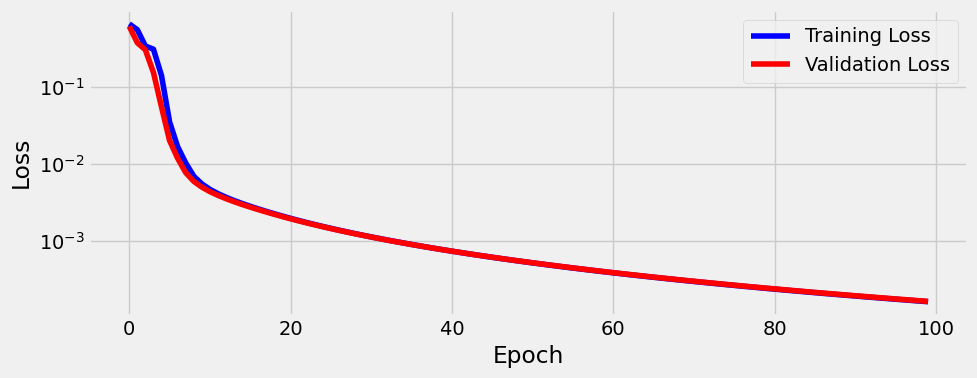

In [33]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss", c="b")
plt.plot(val_losses, label="Validation Loss", c="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()

In [34]:
corrects = 0
val_corrects = 0
for x, t in train_loader:
    x = x.to(device)
    t = t.to(device)
    with torch.no_grad():
        y = model(x)
        p = (torch.sigmoid(y) > 0.5).long()
        corrects += sum(p == t)
for x, t in test_loader:
    x = x.to(device)
    t = t.to(device)
    with torch.no_grad():
        y = model(x)
        p = (torch.sigmoid(y) > 0.5).long()
        val_corrects += sum(p == t)
acc = corrects / 128
val_acc = val_corrects / 128
print(f"training accuracy: {acc}, validation accuracy: {val_acc}")

training accuracy: tensor([1.]), validation accuracy: tensor([1.])


## 4. Quad Vertex Sequence to Sequence

### 4.1 Data Preparation

In [35]:
train_data_gen = QuadVertexSeqGenerator(n_samples=256, n_vertices=4, seed=13)
quads, _ = train_data_gen()
x_train = torch.as_tensor(quads).float()
t_train = x_train[:, 2:]
train_set = TensorDataset(x_train, t_train)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

In [36]:
val_data_gen = QuadVertexSeqGenerator(n_samples=128, n_vertices=4, seed=17)
val_quads, _ = val_data_gen()
val_data = torch.as_tensor(val_quads).float()
x_val = val_data[:, :2]
t_val = val_data[:, 2:]
val_set = TensorDataset(x_val, t_val)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size)

### 4.2 Model Configuration

In [37]:
class QuadVertexSeq2Seq(Transformer):
    def __init__(
        self, 
        n_layers: int,
        input_dim: int, 
        embed_dim: int,
        ffn_hidden_dim: int,
        n_heads: int, 
        max_seq_len: int,
        source_seq_len: int,
        target_seq_len: int,
        dropout_rate: float = 0.1
    ):
        super().__init__(
            n_layers=n_layers,
            input_dim=input_dim,
            embed_dim=embed_dim,
            ffn_hidden_dim=ffn_hidden_dim,
            n_heads=n_heads,
            max_seq_len=max_seq_len,
            dropout_rate=dropout_rate
        )

        self.source_seq_len = source_seq_len
        self.target_seq_len = target_seq_len

    def forward(self, full_seq: torch.Tensor) -> torch.Tensor:
        src_seq = full_seq[:, :self.source_seq_len, :]  # (B, S, E)
        hid_seq = self.encoders(src_seq)
        if self.training:
            shft_seq = full_seq[:, self.source_seq_len-1:-1, :]
            pred_seq = self.decoders(shft_seq, hid_seq, is_masked=True)
        else:
            pred_seq = self.generate(src_seq, hid_seq, is_masked=True)
        return pred_seq

    def generate(
        self, 
        src_seq: torch.Tensor,
        hid_seq: torch.Tensor,
        is_masked: bool = True
    ) -> torch.Tensor:
        shft_seq = src_seq[:, -1:]
        # shft_hid = hid_seq[:, -1:]
        for i in range(self.target_seq_len):
            shft_hid = hid_seq[:, :i+1]
            pred_seq = self.decoders(shft_seq, shft_hid, True)  # (B, S, E)
            shft_seq = torch.cat([shft_seq, pred_seq[:, -1:]], dim=-2)
        pred_seq = shft_seq[:, 1:]
        return pred_seq

In [38]:
model = QuadVertexSeq2Seq(
    n_layers=2,
    input_dim=2,
    embed_dim=6,
    n_heads=3,
    ffn_hidden_dim=10,
    source_seq_len=2,
    target_seq_len=2,
    max_seq_len=4,
    dropout_rate=0.1
)
model.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.01)

### 4.3 Model Training

In [39]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [40]:
torch.autograd.set_detect_anomaly(True)

n_epochs = 50

losses = []
val_losses = []
for e in range(n_epochs):
    model.train()
    batch_losses = []
    for x, t in train_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = loss_fn(y, t)
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))

    model.eval()
    val_batch_losses = []
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        with torch.no_grad():
            y = model(x)
            val_loss = loss_fn(y, t)
        val_batch_losses.append(val_loss.item())
    val_losses.append(np.mean(val_batch_losses))

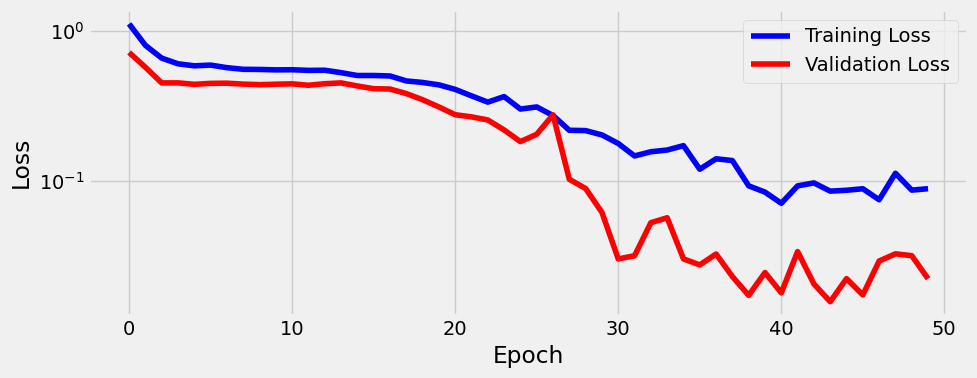

In [41]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss", c="b")
plt.plot(val_losses, label="Validation Loss", c="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()